# TikTok Dataset

# Bussiness Problem Understanding

TikTok users have the ability to report videos and comments that contain user claims. These reports identify content that needs to be reviewed by moderators. This process generates a large number of user reports that are difficult to address quickly. 


TikTok is working on the development of a predictive model that can determine whether a video contains a claim or offers an opinion. Videos that are labeled opinions will be less likely to go on to be reviewed by a human moderator. Videos that are labeled as claims will be further sorted by a downstream process to determine whether they should get prioritized for review. 

With a successful prediction model, TikTok can reduce the backlog of user reports and prioritize them more efficiently.



# Data Understanding

### Attribute Information

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| # | int | TikTok assigned number for video with claim/opinion. |
| claim_status | obj | Whether the published video has been identified as an “opinion” or a “claim.” In this dataset, an “opinion” refers to an individual’s or group’s personal belief or thought. A “claim” refers to information that is either unsourced or from an unverified source. |
| video_id | int | Random identifying number assigned to video upon publication on TikTok. |
| video_duration_sec | int | How long the published video is measured in seconds. |
| video_transcription_text | obj | Transcribed text of the words spoken in the published video. |
| verified_status | obj | Indicates the status of the TikTok user who published the video in terms of their verification, either “verified” or “not verified.”  |
| author_ban_status | Text | Indicates the status of the TikTok user who published the video in terms of their permissions: “active,” “under scrutiny,” or “banned.”   |
| video_view_count | float | The total number of times the published video has been viewed.  |
| video_like_count | float | The total number of times the published video has been liked by other users.  |
| video_share_count | float | The total number of times the published video has been shared by other users.  |
| video_download_count | float | The total number of times the published video has been downloaded by other users.  |
| video_comment_count | float | The total number of comments on the published video. |

In [1]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve



# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [2]:
# Load Dataset
df = pd.read_csv('tiktok_dataset.csv')
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [3]:
# Count and Datatype for each Column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Dataset contains both float64, int64 and object. there are some column with missing values like claim status, video transcript and all the metadata about that video

In [4]:
# Get number of rows and columns
df.shape

(19382, 12)

In [5]:
# Get data types of columns
df.dtypes

#                             int64
claim_status                 object
video_id                      int64
video_duration_sec            int64
video_transcription_text     object
verified_status              object
author_ban_status            object
video_view_count            float64
video_like_count            float64
video_share_count           float64
video_download_count        float64
video_comment_count         float64
dtype: object

In [6]:
# Generate basic descriptive stats
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


the distribution most likely a left skewed because of the standard deviation is pretty high and it seems the outliers are at the high end of the distribution

### Data Cleaning

There are some missing values on certain column. Missing values handling are needed so the dataset can be analyzed for the making of machine learning model

In [7]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,#,int64,0,0.00,19382,"[10091, 11736]"
1,claim_status,object,298,1.54,2,"[nan, opinion]"
2,video_id,int64,0,0.00,19382,"[4051905038, 6271082310]"
3,video_duration_sec,int64,0,0.00,56,"[30, 29]"
4,video_transcription_text,object,298,1.54,19012,[my colleagues' understanding is that the chic...
5,verified_status,object,0,0.00,2,"[verified, not verified]"
6,author_ban_status,object,0,0.00,3,"[active, banned]"
7,video_view_count,float64,298,1.54,15632,"[740842.0, 3417.0]"
8,video_like_count,float64,298,1.54,12224,"[327496.0, 369303.0]"
9,video_share_count,float64,298,1.54,9231,"[2216.0, 3586.0]"


Because there is no better options to handle the missing values, we'll decide to just drop the rows that contain missing values  

In [8]:
df = df.dropna(axis=0)

In [9]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,#,int64,0,0.0,19084,"[10918, 4945]"
1,claim_status,object,0,0.0,2,"[claim, opinion]"
2,video_id,int64,0,0.0,19084,"[4737529998, 3274928888]"
3,video_duration_sec,int64,0,0.0,56,"[29, 32]"
4,video_transcription_text,object,0,0.0,19012,[a friend learned in a discussion board a cla...
5,verified_status,object,0,0.0,2,"[not verified, verified]"
6,author_ban_status,object,0,0.0,3,"[active, under review]"
7,video_view_count,float64,0,0.0,15632,"[6722.0, 2032.0]"
8,video_like_count,float64,0,0.0,12224,"[318203.0, 527351.0]"
9,video_share_count,float64,0,0.0,9231,"[112307.0, 921.0]"


# Exploratory Data Analysis

In [10]:
# What is the average view count of videos with "claim" status?
claim_mask = df['claim_status'] == 'claim'

avg_claim_count = df.loc[claim_mask,'video_view_count'].mean()
med_claim_count = df.loc[claim_mask,'video_view_count'].median()

print(f'the average of videos with CLAIM status is {avg_claim_count}')
print(f'the median of videos with CLAIM status is {med_claim_count}')


the average of videos with CLAIM status is 501029.4527477102
the median of videos with CLAIM status is 501555.0


In [11]:
# What is the average view count of videos with "opinion" status?
opinion_mask = df['claim_status'] == 'opinion'

avg_opinion_count = df.loc[opinion_mask,'video_view_count'].mean()
med_opinion_count = df.loc[opinion_mask,'video_view_count'].median()

print(f'the average of videos with OPINION status is {avg_opinion_count}')
print(f'the median of videos with OPINION status is {med_opinion_count}')


the average of videos with OPINION status is 4956.43224989447
the median of videos with OPINION status is 4953.0


the mean and median of each claim status are pretty close to each other. and also there are no such a big difference between videos labeled as claims and opinion

In [12]:
# Get counts for each group combination of claim status and author ban status
df.groupby(['claim_status', 'author_ban_status']).count()[['#']]

#
claim_status author_ban_status      
claim        active             6566
             banned             1439
             under review       1603
opinion      active             8817
             banned              196
             under review        463

It looks like most of the opinion videos are from an active account compared to claim videos that got more banned and under review account

In [13]:
df.groupby('author_ban_status')['video_share_count'].median()

author_ban_status
active            437.0
banned          14468.0
under review     9444.0
Name: video_share_count, dtype: float64

In [14]:
# What's the median video share count of each author ban status?
df.groupby('author_ban_status')[['video_share_count']].median()

,video_share_count
author_ban_status,
active,437.0
banned,14468.0
under review,9444.0


Most of the videos are shared by banned accounts. there is a vast discrepancy between share count from active and banned accounts.

In [15]:
df.groupby('author_ban_status').agg({
    'video_view_count': ['count', 'mean', 'median'],
    'video_like_count': ['count', 'mean', 'median'],
    'video_share_count': ['count', 'mean', 'median']
})

video_view_count                          video_like_count  \
                             count           mean    median            count   
author_ban_status                                                              
active                       15383  215927.039524    8616.0            15383   
banned                        1635  445845.439144  448201.0             1635   
under review                  2066  392204.836399  365245.5             2066   

                                           video_share_count                \
                            mean    median             count          mean   
author_ban_status                                                            
active              71036.533836    2222.0             15383  14111.466164   
banned             153017.236697  105573.0              1635  29998.942508   
under review       128718.050339   71204.5              2066  25774.696999   

                            
                    median  
author_ban_status           
active               437.0  
banned             14468.0  
under review        9444.0

* both of the banned and under review account got way more views, likes and also shares even with less video being uploaded
* the distribution in most group are left skewed, which means that there are videos with way more engagements from the others

#### **video_duration_sec**

Create visualization to examine the spread of values in the `video_duration_sec` column.

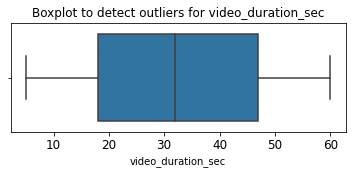

In [16]:
# Create a boxplot to visualize distribution of `video_duration_sec`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_duration_sec', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['video_duration_sec'])
plt.show()

Text(0.5, 1.0, 'Video duration histogram')

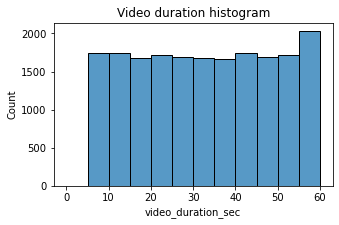

In [17]:
plt.figure(figsize=(5,3))
sns.histplot(df['video_duration_sec'], bins=range(0,61,5))
plt.title('Video duration histogram')


All videos are 5-60 seconds in length, and the distribution is uniform.

#### **video_view_count**

Create visualization to examine the spread of values in the `video_view_count` column.

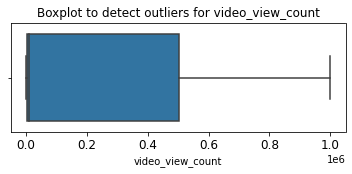

In [18]:
# Create a boxplot to visualize distribution of `video_view_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_view_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['video_view_count'])
plt.show()

Text(0.5, 1.0, 'Video view count histogram')

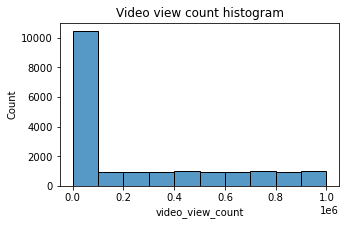

In [19]:
plt.figure(figsize=(5,3))
sns.histplot(df['video_view_count'], bins=range(0,(10**6+1),10**5))
plt.title('Video view count histogram')

This variable has a very uneven distribution, with more than half the videos receiving fewer than 100,000 views. Distribution of view counts > 100,000 views is uniform.

#### **video_like_count**

Create visualization to examine the spread of values in the `video_like_count` column.

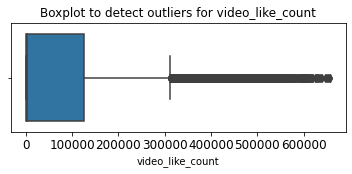

In [20]:
# Create a boxplot to visualize distribution of `video_like_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_like_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['video_like_count'])
plt.show()

Text(0.5, 1.0, 'Video like count histogram')

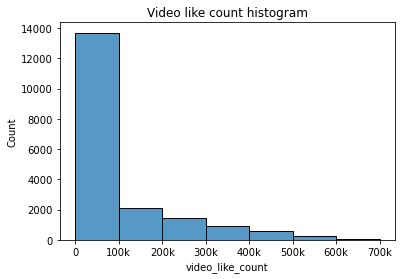

In [21]:
# plt.figure(figsize=(5,3))
ax = sns.histplot(df['video_like_count'], bins=range(0,(7*10**5+1),10**5))
labels = [0] + [str(i) + 'k' for i in range(100, 701, 100)]
ax.set_xticks(range(0,7*10**5+1,10**5), labels=labels)
plt.title('Video like count histogram')

Similar to view count, there are far more videos with < 100,000 likes than there are videos with more. However, in this case, there is more of a taper, as the data skews right, with many videos at the upper extremity of like count.

#### **video_comment_count**

Create visualization to examine the spread of values in the `video_comment_count` column.

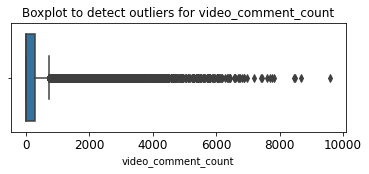

In [22]:
# Create a boxplot to visualize distribution of `video_comment_count`
plt.figure(figsize=(6,2))
plt.title('Boxplot to detect outliers for video_comment_count', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df['video_comment_count'])
plt.show()

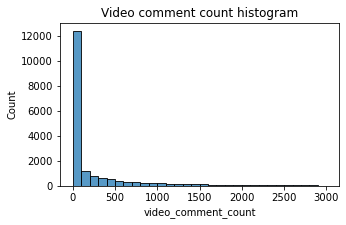

In [23]:
plt.figure(figsize=(5,3))
sns.histplot(df['video_comment_count'], bins=range(0,(3001),100))
plt.title('Video comment count histogram');

#### **video_share_count**

Create visualization to examine the spread of values in the `video_share_count` column.

<AxesSubplot:title={'center':'video_share_count'}, xlabel='video_share_count'>

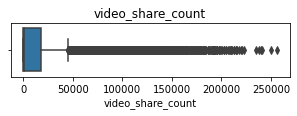

In [24]:
# Create a boxplot to visualize distribution of `video_share_count`
plt.figure(figsize=(5,1))
plt.title('video_share_count')
sns.boxplot(x=df['video_share_count'])

Text(0.5, 1.0, 'Video share count histogram')

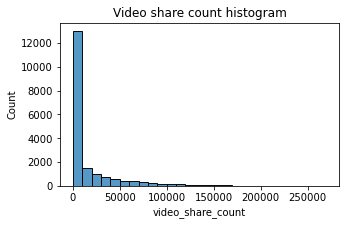

In [25]:
plt.figure(figsize=(5,3))
sns.histplot(df['video_share_count'], bins=range(0,(270001),10000))
plt.title('Video share count histogram')

The overwhelming majority of videos had fewer than 10,000 shares. The distribution is very skewed to the right.

#### **video_download_count**

Create visualization to examine the spread of values in the `video_download_count` column.

<AxesSubplot:title={'center':'video_download_count'}, xlabel='video_download_count'>

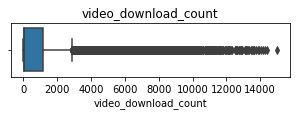

In [26]:
# Create a boxplot to visualize distribution of `video_download_count`
plt.figure(figsize=(5,1))
plt.title('video_download_count')
sns.boxplot(x=df['video_download_count'])

Text(0.5, 1.0, 'Video download count histogram')

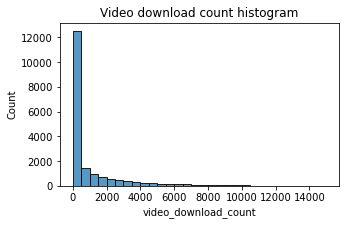

In [27]:
plt.figure(figsize=(5,3))
sns.histplot(df['video_download_count'], bins=range(0,(15001),500))
plt.title('Video download count histogram')

The majority of videos were downloaded fewer than 500 times, but some were downloaded over 12,000 times. Again, the data is very skewed to the right.

#### **Claim status by verification status**

Text(0.5, 1.0, 'Claims by verification status histogram')

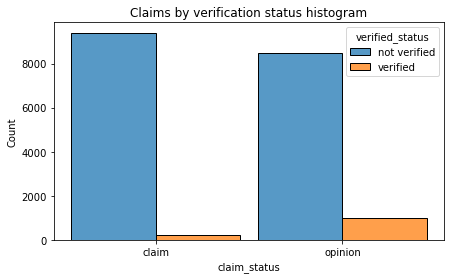

In [28]:
plt.figure(figsize=(7,4))
sns.histplot(data=df,
             x='claim_status',
             hue='verified_status',
             multiple='dodge',
             shrink=0.9)
plt.title('Claims by verification status histogram')

There are far fewer verified users than unverified users, but if a user *is* verified, they are much more likely to post opinions.

#### **Claim status by author ban status**

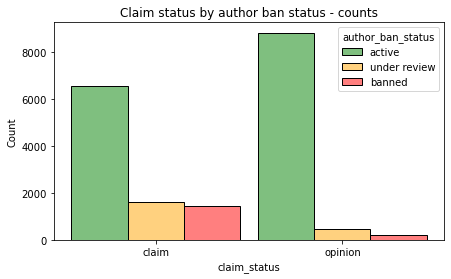

In [29]:
fig = plt.figure(figsize=(7,4))
sns.histplot(df, x='claim_status', hue='author_ban_status',
             multiple='dodge',
             hue_order=['active', 'under review', 'banned'],
             shrink=0.9,
             palette={'active':'green', 'under review':'orange', 'banned':'red'},
             alpha=0.5)
plt.title('Claim status by author ban status - counts');

For both claims and opinions, there are many more active authors than banned authors or authors under review; however, the proportion of active authors is far greater for opinion videos than for claim videos. Again, it seems that authors who post claim videos are more likely to come under review and/or get banned.

#### **Median view counts by ban status**

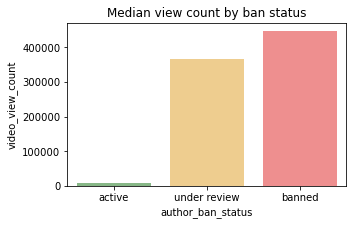

In [30]:
ban_status_counts = df.groupby(['author_ban_status']).median(
    numeric_only=True).reset_index()

fig = plt.figure(figsize=(5,3))
sns.barplot(data=ban_status_counts,
            x='author_ban_status',
            y='video_view_count',
            order=['active', 'under review', 'banned'],
            palette={'active':'green', 'under review':'orange', 'banned':'red'},
            alpha=0.5)
plt.title('Median view count by ban status');

The median view counts for non-active authors are many times greater than the median view count for active authors. Since the non-active authors are more likely to post claims, and that videos by non-active authors get far more views on aggregate than videos by active authors, then `video_view_count` might be a good indicator of claim status.

In [31]:
df.groupby('claim_status')['video_view_count'].median()

claim_status
claim      501555.0
opinion      4953.0
Name: video_view_count, dtype: float64

#### **Total views by claim status**

Create a pie graph that depicts the proportions of total views for claim videos and total views for opinion videos.

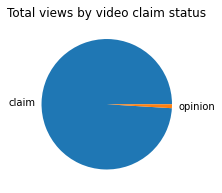

In [32]:
fig = plt.figure(figsize=(3,3))
plt.pie(df.groupby('claim_status')['video_view_count'].sum(), labels=['claim', 'opinion'])
plt.title('Total views by video claim status');

The majority of videos were downloaded fewer than 500 times, but some were downloaded over 12,000 times. Again, the data is very skewed to the right.

#### Examine Outliers

In [33]:
count_cols = ['video_view_count',
              'video_like_count',
              'video_share_count',
              'video_download_count',
              'video_comment_count',
              ]

for column in count_cols:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    median = df[column].median()
    outlier_threshold = median + 1.5*iqr

    # Count the number of values that exceed the outlier threshold
    outlier_count = (df[column] > outlier_threshold).sum()
    print(f'Number of outliers, {column}:', outlier_count)

Number of outliers, video_view_count: 2343
Number of outliers, video_like_count: 3468
Number of outliers, video_share_count: 3732
Number of outliers, video_download_count: 3733
Number of outliers, video_comment_count: 3882


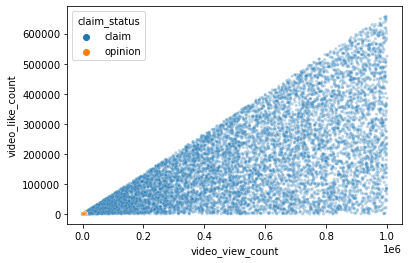

In [34]:
# Create a scatterplot of `video_view_count` versus `video_like_count` according to 'claim_status'
sns.scatterplot(x=df["video_view_count"], y=df["video_like_count"],
                hue=df["claim_status"], s=10, alpha=.3)
plt.show()

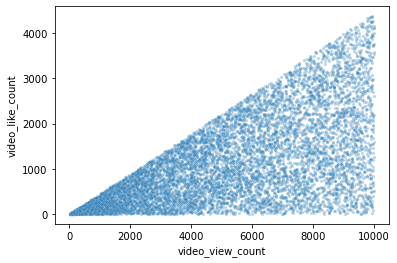

In [35]:
# Create a scatterplot of `video_view_count` versus `video_like_count` for opinions only
opinion = df[df['claim_status']=='opinion']
sns.scatterplot(x=opinion["video_view_count"], y=opinion["video_like_count"],
                 s=10, alpha=.3)
plt.show()

### Examine Correlations

In [36]:
# correlation matrix help determine most correlated variables
df.corr()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
#,1.000000,-0.003590,-0.000145,-0.668047,-0.540852,-0.451713,-0.447729,-0.377445
video_id,-0.003590,1.000000,0.008460,0.000217,0.000236,-0.002721,0.002155,0.005336
video_duration_sec,-0.000145,0.008460,1.000000,0.008481,0.011567,0.011560,0.013078,0.000615
video_view_count,-0.668047,0.000217,0.008481,1.000000,0.804322,0.665635,0.664222,0.554172
video_like_count,-0.540852,0.000236,0.011567,0.804322,1.000000,0.825789,0.823554,0.687185
video_share_count,-0.451713,-0.002721,0.011560,0.665635,0.825789,1.000000,0.679910,0.574632
video_download_count,-0.447729,0.002155,0.013078,0.664222,0.823554,0.679910,1.000000,0.832464
video_comment_count,-0.377445,0.005336,0.000615,0.554172,0.687185,0.574632,0.832464,1.000000


Visualize a correlation heatmap of the data.

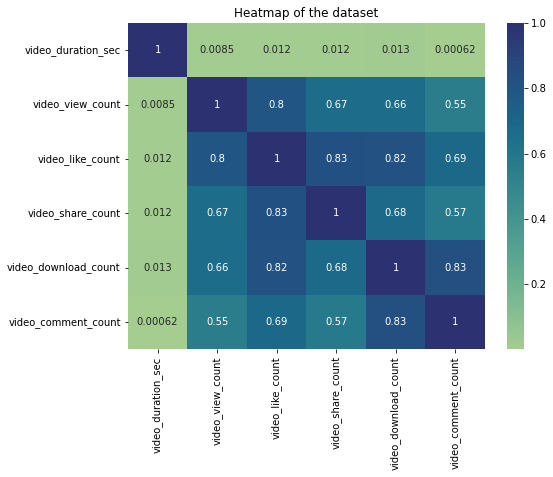

In [37]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    df[["video_duration_sec", "claim_status", "author_ban_status", "video_view_count", 
                    "video_like_count", "video_share_count", "video_download_count", "video_comment_count"]]
    .corr(), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

The heatmap shows that the following pair of variables are strongly correlated, which are `video_view_count` and `video_like_count` (0.86 correlation coefficient). But it is common on social media where views are in direct proportions with other metric such as likes

# Machine Learning

## Data Preperation

In [38]:
# Create `text_length` column
df['text_length'] = df['video_transcription_text'].str.len()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Let's check if average video_transcription_text length is different for both claim and opinion.

In [39]:
# extraction of the length of each video_transcription_text 
df[['claim_status','text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


<AxesSubplot:title={'center':'video transcrition text length (number of characters)'}, xlabel='text_length', ylabel='Count'>

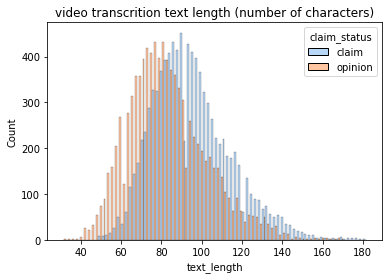

In [40]:
#visualize the distribution of video transcription text length for the claim status
plt.title('video transcrition text length (number of characters)')
sns.histplot(data=df,x='text_length',hue='claim_status',kde=False,multiple='dodge',stat='count', palette='pastel'
            ,element='bars',legend=True)

Encode target and categorical variables

In [41]:
df = df.drop(columns = ['#', 'video_id'])
df['claim_status'] = df['claim_status'].replace({'opinion': 0, 'claim': 1})
df.head()

,claim_status,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,1,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,1,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,1,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,1,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [42]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(ngram_range = (2,3),
                           max_features = 15,
                           stop_words = 'english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [43]:
count = count_vec.fit_transform(df['video_transcription_text']).toarray()
count_df = pd.DataFrame(data = count, columns = count_vec.get_feature_names_out())
df_final = pd.concat([df.drop(columns = ['video_transcription_text']).reset_index(drop = True), count_df], axis = 1)
df_final.head()

,claim_status,video_duration_sec,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,colleague discovered,colleague learned,colleague read,discussion board,friend learned,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,1,59,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,32,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,31,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,25,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,19,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
df_final.shape

(19084, 25)

In [45]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19084 entries, 0 to 19083
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   claim_status          19084 non-null  int64  
 1   video_duration_sec    19084 non-null  int64  
 2   verified_status       19084 non-null  object 
 3   author_ban_status     19084 non-null  object 
 4   video_view_count      19084 non-null  float64
 5   video_like_count      19084 non-null  float64
 6   video_share_count     19084 non-null  float64
 7   video_download_count  19084 non-null  float64
 8   video_comment_count   19084 non-null  float64
 9   text_length           19084 non-null  int64  
 10  colleague discovered  19084 non-null  int64  
 11  colleague learned     19084 non-null  int64  
 12  colleague read        19084 non-null  int64  
 13  discussion board      19084 non-null  int64  
 14  friend learned        19084 non-null  int64  
 15  friend read        

In [46]:
# Transform every categorical columns into numerical
transformer = ColumnTransformer([("onehot", OneHotEncoder(drop='first', handle_unknown='ignore'), ['verified_status','author_ban_status']),
],remainder='passthrough')

In [47]:
y = df_final['claim_status']
x = df_final.drop(columns = ['claim_status'])

In [48]:
# Checking if our transform fit correctly or not
transformer.fit_transform(x)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Split data into training and testing sets, 80/20.

In [49]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((15267, 24), (3817, 24), (15267,), (3817,))

## Modeling & Evaluation

In [50]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()

### Model Benchmarking : K-fold

In [51]:
models = [logreg,knn,dt,rf,xgb]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

,mean roc_auc,sdev
model,,
Random Forest,0.998972,0.000861
XGBoost,0.998589,0.000597
Decision Tree,0.996069,0.000851
KNN,0.995860,0.001066
Logistic Regression,0.993077,0.001533


As we can see that random forest performs better than other model based on roc_auc on every model with default hyperparameter

### Model Benchmarking : Test Data

In [52]:
models = [logreg,knn,dt,rf,xgb]
score_roc_auc = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test
    
    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost']):
    estimator,y_pred,x_test = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1889
           1       1.00      0.98      0.99      1928

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817

KNN 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1889
           1       1.00      0.99      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

Decision Tree 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1889
           1       1.00      1.00      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1

,roc_auc score
model,
XGBoost,0.998982
Random Forest,0.998762
Decision Tree,0.996591
KNN,0.995727
Logistic Regression,0.993702


But the performance on the test data, XGB performs better than random forest classification. We'll choose the best model by comparing the result of these two models

### **Build a XGBoost model**

In [53]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

estimator=Pipeline([
    ('preprocess',transformer),
    ('model',rf)
])

hyperparam_space = {
    'model__max_depth': [4,8,12],
    'model__max_features': [0.3, 0.6],
    'model__n_estimators': [300, 500]
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring=scoring, cv=5, refit='recall')

In [54]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9959635416666666
{'model__max_depth': 12, 'model__max_features': 0.6, 'model__n_estimators': 300}


In [55]:
grid.best_score_

0.9959635416666666

In [56]:
grid.best_params_

{'model__max_depth': 12,
 'model__max_features': 0.6,
 'model__n_estimators': 300}

In [57]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['verified_status',
                                                   'author_ban_status'])])),
                ('model',
                 RandomForestClassifier(max_depth=12, max_features=0.6,
                                        n_estimators=300))])

In [58]:
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',xgb)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['verified_status',
                                                   'author_ban_status'])])),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               ena...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=0, ...))])

In [59]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default XGB : ', roc_auc_default)
print('ROC AUC Score Tuned XGB : ', roc_auc_tuned)

ROC AUC Score Default XGB :  0.9989818758525555
ROC AUC Score Tuned XGB :  0.9989044456989473


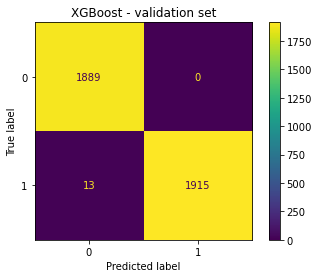

In [60]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set')
plt.show()


In [61]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1889
       claim       1.00      0.99      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



The results of the XGBoost model were also nearly perfect. However, its errors tended to be false negatives. Identifying claims was the priority, so it's important that the model be good at capturing all actual claim videos.

### **Build a Random Forest model**

In [62]:
rf = RandomForestClassifier()

estimator=Pipeline([
    ('preprocess',transformer),
    ('model',rf)
])

hyperparam_space = {
    'model__max_depth': [5, 7, None],
    'model__max_features': [0.3, 0.6],
    'model__max_samples': [0.7],
    'model__min_samples_leaf': [1,2],
    'model__min_samples_split': [2,3],
    'model__n_estimators': [75,100,200],
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring=scoring, cv=5, refit='recall')

In [63]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

0.9959635416666666
{'model__max_depth': None, 'model__max_features': 0.3, 'model__max_samples': 0.7, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}


The best hyperparameter for random forest classifier based on the result of grid search are `max_features` = 0.6, `max_samples` = 0.7, `min_samples_leaf` = 1, `min_samples_split` = 2, `n_estimators` = 75

In [64]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['verified_status',
                                                   'author_ban_status'])])),
                ('model',
                 RandomForestClassifier(max_features=0.3, max_samples=0.7,
                                        n_estimators=200))])

In [65]:
estimator=Pipeline([
    ('preprocess',transformer),
    ('model',rf)
])
estimator.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['verified_status',
                                                   'author_ban_status'])])),
                ('model', RandomForestClassifier())])

In [66]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default RF : ', roc_auc_default)
print('ROC AUC Score Tuned RF : ', roc_auc_tuned)

ROC AUC Score Default RF :  0.9990302010548074
ROC AUC Score Tuned RF :  0.9991851986495301


Based on the result above, random forest classifier performs slightly worse after the hyperparameter are being tuned. But still their performance are great.

In [67]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default RF : \n', report_default)
print('Classification Report Tuned RF : \n', report_tuned)

Classification Report Default RF : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1889
           1       1.00      1.00      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817

Classification Report Tuned RF : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1889
           1       1.00      0.99      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



Based on the classification report, the model's performance are perfect both on the default hyperparameter and the one that being tuned.

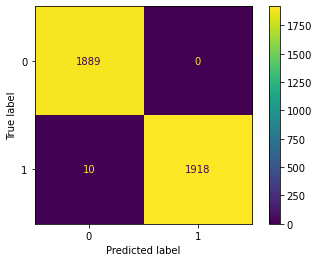

In [68]:
# Create a confusion matrix to visualize the results of the classification model

# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred_tuned)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.show()

Both random forest and XGBoost model architectures resulted in nearly perfect models. Nonetheless, in this case random forest performed a little bit better, so it is the champion model.

### Feature Importances

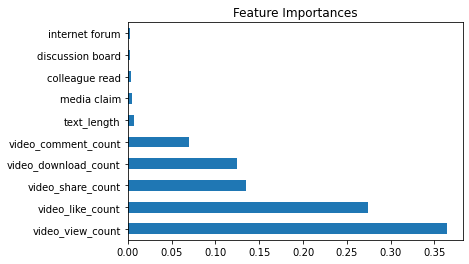

In [69]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

# Conclusion & Recommendation

In [70]:
print('Classification Report Tuned RF : \n', report_tuned)

Classification Report Tuned RF : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1889
           1       1.00      0.99      1.00      1928

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



## Conclusion

1. The model performed very well based on the result of both precision and F<sub>1</sub> that consistently high. in conclusion, the model successfully classified which videos are claims and opinions
2. Based on the features importance visualization, the most predictive features were all related to the metrics of a video. it was classifying based on all realted to engagement levels like views, shares, downloads of a video.

## Recommendation

1. To make a lot more better model, larger datasets are needed with a lot more various records in it.
2. New features are also needed for improvement such as user's followers which can be calculated to gain ER (Engagement Rates) from every users that post videos.
3. It would be helpful to have the number of times the video was reported. It would also be useful to have the total number of user reports for all videos posted by each author.